# Using RANSAC to compute homographies

In [4]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt

## Variables definition

In [5]:
#Directories definition
dataset_dir = 'datasets\house_dataset'
sift_dir = 'sift'
matches_dir = 'matches'
salient_matches_dir ="salient_matches"

In [6]:
#Variables definition
kps=[] #Array that will contain key-points of each image
dess=[] #Array that will contain the descriptors of each image

## Functions definition

In [7]:
#This function loads images from a specific folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [8]:
#This function uses SIFT algorithm to retrieve the key points of an image
def SIFT(img):
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(img,None)
    img_with_sift=cv.drawKeypoints(img,kp,img)
    return img_with_sift, kp, des

In [14]:
#This function performs feature matching between to images
def feature_matching(img1, img2, kp1, kp2, des1, des2):
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # Need to draw only good matches, so create a mask
    count_m = 0
    good = []
    for m,n in matches:
        #A threshold is used to define the goodness of a match
        if m.distance < 0.6*n.distance:
            good.append((m,n))
    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       flags = cv.DrawMatchesFlags_DEFAULT)
    img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,**draw_params)
    return img3, len(good), good

In [22]:
#This function allows to fit an homography between to images using RANSAC
def fit_hom(match, kps, imgs):
    src_pts = np.float32([ kps[int(match["source"])][m[0].queryIdx].pt for m in match["matches"]]).reshape(-1,1,2)
    dst_pts = np.float32([ kps[int(match["destination"])][m[0].trainIdx].pt for m in match["matches"] ]).reshape(-1,1,2)

    #The homography is the one that brings src_points in dst_points
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    return M

## Example

In [11]:
#Load the dataset
imgs = load_images_from_folder(dataset_dir)

In [12]:
#Compute the key-points for each image
for i in range(0, len(imgs)):
    image_sift, kp, des = SIFT(imgs[i])
    kps.append(kp)
    dess.append(des)
    cv.imwrite(os.path.join(sift_dir,f"sift_{i+1}.jpg"),image_sift)

In [16]:
#Perform feature matching between each pair of images
matched_masks = []
matches = []
for i in range(0, len(imgs)-1):
    for j in range(i+1, len(imgs)):
        img_match, n_matches, matches = feature_matching(imgs[i], imgs[j], kps[i], kps[j], dess[i], dess[j])
        matched_masks.append(img_match)
        cv.imwrite(os.path.join(matches_dir,f"match_{i+1}_{j+1}.jpg"),img_match)

In [18]:
#Perform feature matching keeping only those pairs of images with at least matches_th matches
matches =[]
matches_th = 50
for i in range(0, len(imgs)-1):
    for j in range(i+1, len(imgs)):
        img_match, _ , good = feature_matching(imgs[i], imgs[j], kps[i], kps[j], dess[i], dess[j])
        if len(good) > matches_th:
            matches.append({
                "image":img_match,
                "matches":good,
                "source":i,
                "destination":j
            })
            cv.imwrite(os.path.join(salient_matches_dir,f"salient_{i+1}_{j+1}.jpg"),img_match)

In [23]:
#Create a graph with one node for each image and an arc for each homography between pairs of matched images
graph = np.empty((len(imgs), len(imgs)), dtype=object)
for match in matches:
    graph[int(match["source"]),int(match["destination"])] = fit_hom(match, kps, imgs)
    

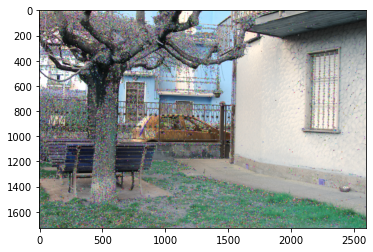

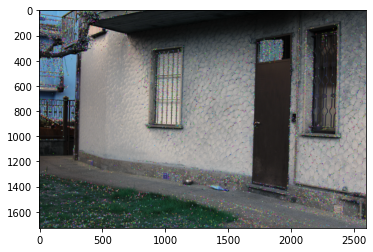

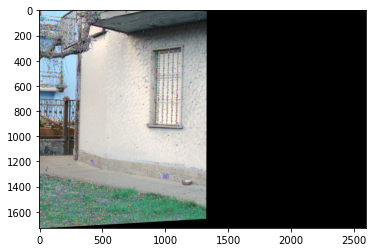

(<matplotlib.image.AxesImage at 0x21d031cb8e0>, None)

In [25]:
#Print an example of the computed homography
index_1 = 2
index_2 = 3

img1 = imgs[index_1] #First image
img2 = imgs[index_2] #Second image
H = graph[index_1,index_2]

#Transform the first image according to the homography
size = img2.shape[0:2][::-1]
im_dst = cv.warpPerspective(img1, H, size)

#Plot images
plt.imshow(img1,),plt.show()
plt.imshow(img2,),plt.show()
plt.imshow(im_dst,),plt.show()